In [23]:
# import dependencies here
import csv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from typing import Dict, List
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
import csv
import hashlib
from typing import Callable, Dict, List

In [24]:
# edit library settings here
pd.set_option('display.max_colwidth', -1)

# list all constants here
DATA_PATH = '/Volumes/TriveStorage/support_vector_machine/scraper-carsdotcom/byecar_data'
COMBINED_CSV_NAME = 'byecar_combined.csv'

def is_csv(file_path: str) -> bool:
    return os.path.splitext(file_path)[1] == '.csv'

def get_csv_files(file_paths: List[str]) -> List[str]:
    return list(filter(is_csv, file_paths))

def csv_to_dict(row: List[str]) -> Dict:
    return {
        'car_id': row[0],
        'name': row[1],
        'description': row[2],
        'badges': row[3],
        'bids': row[4],
        'price': row[5],
        'timestamp': int(row[6]),
    }

def extract_month(row) -> int:
    try:
        return row['description'].split('월')[0].split('년 ')[1]
    except Exception as e:
        print(e)
        return 0

def extract_year(row) -> int:
    try:
        return int(row['description'].split('년')[0])
    except Exception as e:
        print(e)
        return 0

def extract_bid_count(row) -> int:
    try:
        return int(row['bids'].split('회')[0].split('입찰횟수 ')[1])
    except Exception as e:
        print(e)
        return 0
    
def extract_dealer_count(row) -> int:
    try:
        return int(row['bids'].split('명')[0].split('참여딜러 ')[1])
    except Exception as e:
        print(e)
        return 0
    
def extract_accident(row) -> int:
    return '무사고' in row['badges']

def extract_km(row) -> int:
    try:
        return int(row['description'].split(' / ')[1].replace('km', ''))
    except Exception as e:
        print(e)
        return 0

def extract_location(row) -> str:
    return row['description'].split(' / ')[2]

def convert_price(row) -> int:
    try:
        return int(row['price'].split(' 만원')[0].split('현재가 ')[1].replace(',', '')) * 10_000
    except Exception as e:
        print(e)
        return 0

def get_column_value_length(column_name: str) -> Callable:
    def get_column_value_length_x(row) -> int:
        return len(row[column_name])
    return get_column_value_length_x
    
make_dict = {
    '아우디': 'audi',
    '닷지': 'dodge',
    '재규어': 'jaguar',
    '지프': 'jeep',
    '시트로엥': 'citroen',
    '험머': 'hummer',
    '페라리': 'ferrari',
    '애스턴마틴': 'astonmartin',
    '스바루': 'subaru',
    '랜드로버': 'landrover',
    '스마트': 'smart',
    '포드': 'ford',
    '람보르기니': 'lamborghini',
    '쉐보레': 'chevrolet',
    'GM대우': 'chevrolet',
    '쉐보레(GM대우)': 'chevrolet',
    '도요타': 'toyota',
    '볼보': 'volvo',
    '쌍용': 'ssangyong',
    '미니': 'mini',
    '벤츠': 'benz',
    '다이하쯔': 'daihatsu',
    '인피니티': 'infiniti',
    '혼다': 'honda',
    '크라이슬러': 'chrysler',
    '닛산': 'nissan',
    '캐딜락': 'cadillac',
    '미쯔비시': 'mitsubishi',
    '포르쉐': 'porsche',
    '폭스바겐': 'volkswagen',
    '푸조': 'peugeot',
    '기아': 'kia',
    '렉서스': 'lexus',
    '스즈키': 'suzuki',
    '기타': 'other',
    '피아트': 'fiat',
    '링컨': 'lincoln',
    '마세라티': 'maserati',
    '현대': 'hyundai',
    '북기은상': 'baic',
    '제네시스': 'genesis',
    'BMW': 'bmw',
    '벤틀리': 'bentley',
    '르노삼성': 'renaultsamsung',
}

def assign_make(row) -> str:
    first_word = row['name'].split(' ')[0]
    if first_word in make_dict:
        return make_dict[first_word]
    return first_word


In [15]:
# combine all separately scraped ByeCar data into a single csv
if os.path.exists(COMBINED_CSV_NAME):
    os.remove(COMBINED_CSV_NAME)
combined_byecar = open(COMBINED_CSV_NAME, 'w')
writer_combined_byecar = csv.writer(combined_byecar, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

csv_names = get_csv_files(os.listdir(DATA_PATH))
for csv_name in csv_names:
    timestamp = int(os.path.splitext(csv_name)[0])
    with open(os.path.join(DATA_PATH, csv_name)) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            row.append(timestamp)
            writer_combined_byecar.writerow(row)
combined_byecar.close()

In [16]:
# load all csv data into an intermediate list of dictionaries (for Pandas)
byecar_data_for_dataframe = []

with open(COMBINED_CSV_NAME) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        byecar_data_for_dataframe.append(csv_to_dict(row))

In [17]:
# convert the combined csv into a pandas dataframe, and format columns
df_byecar = pd.DataFrame(byecar_data_for_dataframe)
df_byecar['accident'] = df_byecar.apply(extract_accident, axis=1)
df_byecar = df_byecar.drop(columns='badges')

df_byecar['dealer_count'] = df_byecar.apply(extract_dealer_count, axis=1)
df_byecar['bid_count'] = df_byecar.apply(extract_bid_count, axis=1)
df_byecar = df_byecar.drop(columns='bids')

df_byecar['year'] = df_byecar.apply(extract_year, axis=1)
df_byecar['month'] = df_byecar.apply(extract_month, axis=1)
df_byecar['km'] = df_byecar.apply(extract_km, axis=1)
df_byecar['location'] = df_byecar.apply(extract_location, axis=1)
df_byecar['price'] = df_byecar.apply(convert_price, axis=1)
df_byecar['make'] = df_byecar.apply(assign_make, axis=1)
df_byecar = df_byecar.drop(columns='description')

df_byecar.head()
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print(df_byecar['month'])

,car_id,name,price,timestamp,accident,dealer_count,bid_count,year,month,km,location,make
0,69226,기아 레이 프레스티지,2900000,1547797152,True,8,8,2012,5,39579,광주 북구 동림동,kia
1,69224,포드 익스플로러 2.3 리미티드 4WD,39000000,1547797152,True,2,2,2018,2,17500,서울 강북구 미아동,ford
2,69223,기아 올 뉴 카니발 9인승 프레스티지,16100000,1547797152,True,2,2,2015,7,88105,부산 기장군 정관면,kia
3,69222,렉서스 CT200h 1.8 컴팩트 럭셔리,8600000,1547797152,False,2,2,2011,9,78000,경기 수원시 영통구 영통동,lexus
4,69221,르노삼성 SM5 뉴 임프레션 LE,450000,1547797152,False,3,3,2009,12,39000,경기 성남시 수정구 태평동,renaultsamsung


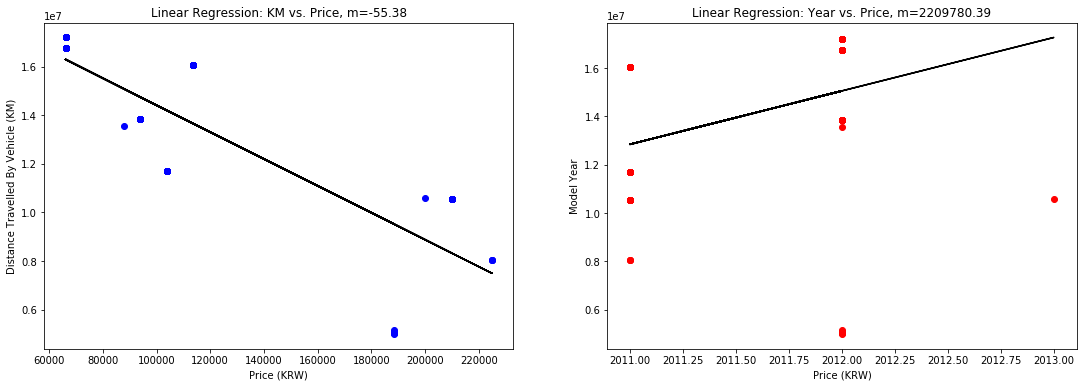

In [18]:
df_data_1 = df_byecar[
    df_byecar['name'].str.contains('현대') &
    df_byecar['name'].str.contains('그랜저') &
    df_byecar['name'].str.contains('HG') &
    df_byecar['name'].str.contains('LPG') &
    df_byecar['name'].str.contains('이그젝큐티브')
]
df_data_1 = df_data_1.drop_duplicates(subset=None, keep='first', inplace=False)
df_data_1.head()
# print(len(df_data_1.index))
# df_data_1.plot(kind='scatter',x='km',y='price',color='red')
# plt.show()

lr_model_1 = LinearRegression()
lr_model_2 = LinearRegression()

X1 = df_data_1['km'].values[:,np.newaxis]
y1 = df_data_1['price'].values

X2 = df_data_1['year'].values[:,np.newaxis]
y2 = df_data_1['price'].values

lr_model_1.fit(X1, y1)
lr_model_2.fit(X2, y2)


fig = plt.figure(1)
fig.set_size_inches(18.5, 6)

ax1 = plt.subplot(121)
ax1.set_title(f'Linear Regression: KM vs. Price, m={"%.2f"%(lr_model_1.coef_[0])}')
ax1.set_xlabel('Price (KRW)')
ax1.set_ylabel('Distance Travelled By Vehicle (KM)')
ax1.scatter(X1, y1, color='b')
ax1.plot(X1, lr_model_1.predict(X1), color='k')

ax2 = plt.subplot(122)
ax2.set_title(f'Linear Regression: Year vs. Price, m={"%.2f"%(lr_model_2.coef_[0])}')
ax2.set_xlabel('Price (KRW)')
ax2.set_ylabel('Model Year')
ax2.scatter(X2, y2, color='r')
ax2.plot(X2, lr_model_2.predict(X2), color='k')

plt.show()

### **Simple Linear Regression** (SLR)
* $y = mx + b$
* Need to choose variables that we think we’ll be good predictors for the dependent variable
* $x$ is the independent (explanatory) variable, number of km driven
* $y$ is the dependent variable, the price (the variable we’re trying to predict/estimate)
* The graph above (left) indicates a negative correlation between distance the vehicle has been driven (in km) and the buying price of the vehicle
* The graph above (right) indicates a weak positive correlation between model year and price
* Residuals are basically the differences between the true value of Y and the predicted/estimated value of Y

### **Multiple Regression** (MR)
$Y = b_0 + b_1X_1 + b_2X_2$

In [25]:
# check for make names not yet covered in make_dict above

# unique_car_names = df_byecar['name'].unique()
# with open('vehicle_names.csv', mode='w') as f:
#     f_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
#     for name in unique_car_names:
#         f_writer.writerow([name,'xxxxxxxxx'])

# first_words = []
# for car_name in unique_car_names:
#     first_word = car_name.split(' ')[0]
#     if first_word not in make_dict:
#         first_words.append(first_word)

# first_words = list(set(first_words))

In [69]:
# https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f
vehicle_names = []
with open('vehicle_name_data.csv') as f:
    f_reader = csv.reader(f, delimiter=',')
    for row in f_reader:
        if row[1] != 'xxxxxxxxx':
            vehicle_names.append({'name': row[0].lower(), 'value': row[1]})

df_vehicle_names = pd.DataFrame(vehicle_names)
df_vehicle_names.head()

X_train, X_test, y_train, y_test = train_test_split(df_vehicle_names['name'], df_vehicle_names['value'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
nb_clf = MultinomialNB().fit(X_train_tfidf, y_train)
# print(nb_clf.predict(count_vect.transform(['르노삼성 SM6 2.0 GDe RE', '르노삼성 SM6 2.0 GDe RE'])))


In [21]:
# an example of generating a SHA-256 key value for a raw vehicle name
def generate_hash_key(raw_value: str) -> str:
    return hashlib.sha256(raw_value.encode()).hexdigest()

df_hash_keys = pd.DataFrame(list(map(lambda x: {'raw': x, 'hashed': generate_hash_key(x)}, [
    '현대 그랜저 IG 2.4 프리미엄 스페셜',
    '현대 그랜저 IG 3.0 익스클루시브',
    '현대 그랜저 IG 3.3 셀러브리티',
    '현대 그랜저 IG 2.4 프리미엄',
    '현대 그랜저 IG 3.0 LPi 익스클루시브',
    '현대 그랜저 IG 3.0 익스클루시브 스페셜',
    '현대 그랜저 IG 2.2 디젤 프리미엄 스페셜',
    '현대 그랜저 IG 2.2 디젤 모던',
    '현대 그랜저 IG 2.2 디젤 프리미엄',
    '현대 그랜저 IG 3.0 LPi 장애인용 프리미엄 스페셜',
    '현대 그랜저 IG 2.4 모던',
    '현대 그랜저 IG 3.0 LPi 모던',
    '현대 그랜저 IG 3.0 모던 베이직 (렌터카)',
    '현대 그랜저 IG 3.0 LPi 모던 베이직',
    '현대 그랜저 IG 3.0 LPi 장애인용 익스클루시브 스페셜',
])))

df_hash_keys['hashed_key_length'] = df_hash_keys.apply(get_column_value_length('hashed'), axis=1)
df_hash_keys.head()

,hashed,raw,hashed_key_length
0,b806e1ac0592920ba8acabb00c69365d2b0393a1579a2b5a39b2a6c37cd640d2,현대 그랜저 IG 2.4 프리미엄 스페셜,64
1,e7370bde75bef5c14a1f92181ec372201afebeeb23a04e0df7c50308ce668a9d,현대 그랜저 IG 3.0 익스클루시브,64
2,024a14d3be501009fa84de1d98083c2c5c96529d8d9bb82b6d0a420c45baef5d,현대 그랜저 IG 3.3 셀러브리티,64
3,912166ca1ab5823b9a940eea2179774b975af419dd773058b2bcd2fbea4c1c0f,현대 그랜저 IG 2.4 프리미엄,64
4,3df2a89a25dabca765e17249c89dda1eb11161568253b0174ab4dfa8338c9813,현대 그랜저 IG 3.0 LPi 익스클루시브,64
